In [13]:
import torch
import numpy as np
import os
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from model import Model
from utils import real_time_sig_process, TP_dect


In [2]:
model_state_path = './model_state_dict/bz32_lr0.001_ep30_in50_out15_h40_layers1_biTrue_dr0.pt'
testset_path = './Dataset/test_set.csv'

In [3]:
MyModel = Model()
MyModel.load_model(model_state_path)

Model parameters loaded!


In [4]:
test_data = pd.read_csv(testset_path, header=None).to_numpy()
test_data_list = [row[~np.isnan(row)] for row in test_data]

In [63]:
sample = test_data_list[0][0:58]
t_start = time.time()
sample = real_time_sig_process(sample, win_len=9, sav_order=5)
sample = torch.Tensor(sample[4:54]).unsqueeze(0).unsqueeze(2)
pred = MyModel.predict(sample).squeeze().numpy()
t_end = time.time()
time_gap = t_end - t_start
print(time_gap)
print(pred.shape)

0.01799321174621582
(15,)


In [94]:
input_win = 50
output_win = 15
filter_win = 9
half_filter_win = int((filter_win - 1) / 2)

prediction = []
tgap_mean = []
for test_data in tqdm(test_data_list, desc='Processing', unit='item'):
    sig_len = len(test_data)
    sig_start = 0
    tgap_list = []
    pred_sig = []
    while (sig_start + input_win + output_win) < sig_len - 1:
        start = time.time()
        sig_end = int(sig_start + input_win + 2 * half_filter_win)
        sample = test_data[sig_start:sig_end]
        sample = real_time_sig_process(sample)
        sample_input = torch.Tensor(sample[half_filter_win:(half_filter_win + input_win)]).unsqueeze(0).unsqueeze(2)
        pred = MyModel.predict(sample_input).squeeze().numpy()
        sig_start += 1
        end = time.time()
        pred_sig.append(pred)
        tgap = end - start
        tgap_list.append(tgap)
        # print(tgap)
    # print(f'index_end{sig_end-4+15}')
    mean_tgap_single_test_data = np.mean(tgap_list)
    tgap_mean.append(mean_tgap_single_test_data)
    prediction.append(pred_sig)

Processing:   0%|          | 0/23 [00:00<?, ?item/s]

Processing: 100%|██████████| 23/23 [27:07<00:00, 70.78s/item]


In [111]:
import csv

for i in range(len(prediction)):
    with open(f'./Dataset/prediction/prediction{i}.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(prediction[i])

In [110]:
prediction[0][0]

array([0.3722766 , 0.3617579 , 0.35398757, 0.3484804 , 0.3488458 ,
       0.35151678, 0.3617275 , 0.3700551 , 0.38394064, 0.40329465,
       0.42852086, 0.46333247, 0.50219756, 0.5427505 , 0.5738457 ],
      dtype=float32)

In [41]:
pred_signal = prediction[0]
signal_len = len(pred_signal) * 15 - 4
origin_signal = test_data_list[0][50:(signal_len + 58)]
origin = real_time_sig_process(origin_signal)[4:(signal_len + 4)]
p = [item for l in pred_signal for item in l]
p = p[:-4]


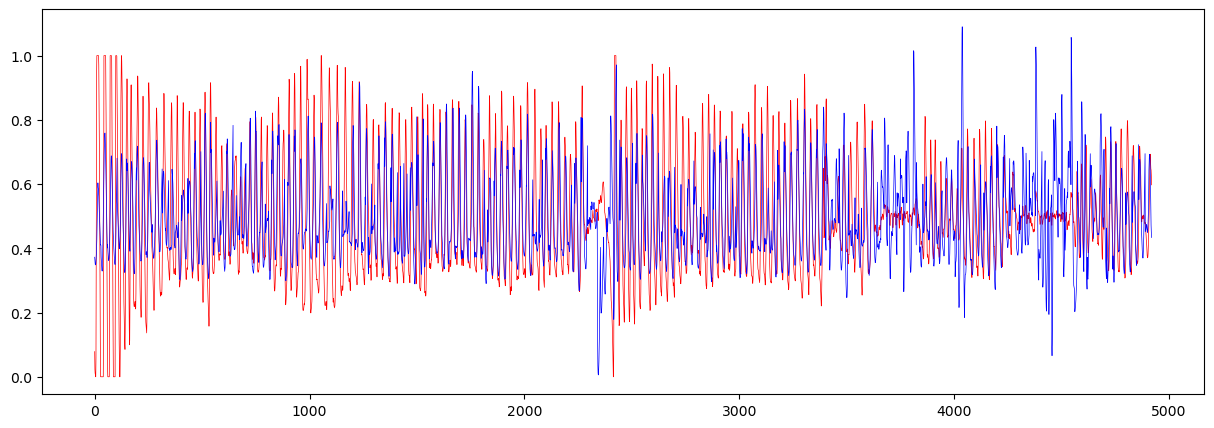

In [42]:
origin = origin[:-11]
p = p[:-11]
x = np.arange(len(p))

fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(x, origin, label='origin', c='r', linestyle='-', linewidth=0.5)
ax.plot(x, p, label='pred', c='b', linestyle='-', linewidth=0.5)
plt.show()

In [12]:
fig.savefig('output.png', dpi=300)

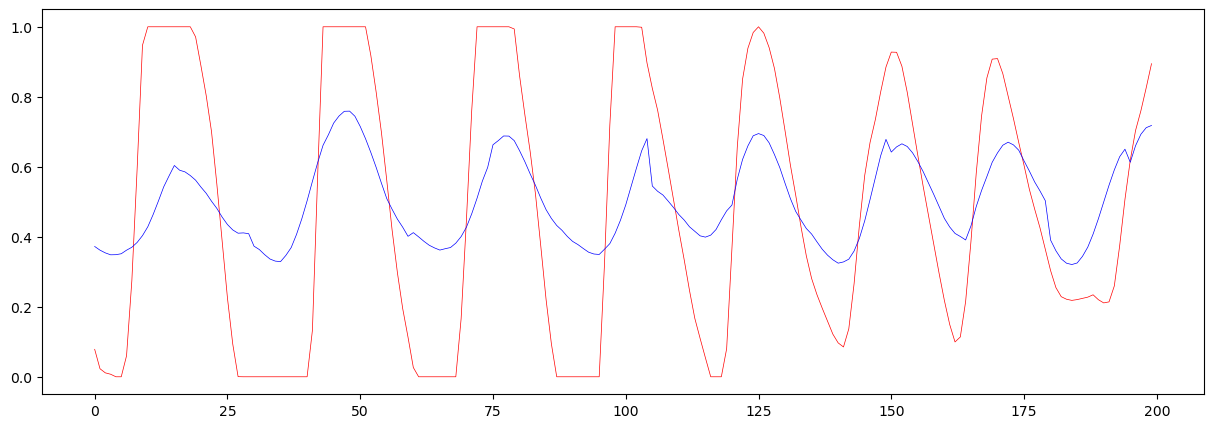

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(x[:200], origin[:200], label='origin', c='r', linestyle='-', linewidth=0.5)
ax.plot(x[:200], p[:200], label='pred', c='b', linestyle='-', linewidth=0.5)
plt.show()

In [72]:
Y_arr = [origin[i_input + 50 : i_input  + 50 + 15] for i_input in range(4856)]

In [18]:
Y_arr = origin.reshape(-1,15)

In [21]:
from math import copysign

def trigger_point_detect(signal, verification=5, clip=0.2, last_time=False):

    sig_diffs = np.diff(signal)
    potential_trps = dict()
    sign = 0
    for idx, sig_diff in enumerate(sig_diffs):
        current_sign = copysign(-1, sig_diff)
        if idx == 0:
            first_sign = current_sign
        if first_sign == current_sign:
            continue
        else:
            if sign != current_sign:
                sign = current_sign
                record_idx = idx
                potential_trps[record_idx] = 1
            
            elif sign == current_sign:
                potential_trps[record_idx] += 1
    
    tr_lists = []
    for key, times in potential_trps.items():
        if times >= verification and abs(signal[key] - 0.5) > clip:
            tr_lists.append(int(key))
            return tr_lists, False
        elif times == (len(signal)-key-1) and key >= (len(signal)-verification) and abs(signal[key] - 0.5) > clip:
            tr_lists.append(int(key))
            return tr_lists, True
            
    # sign = 0
    # time_last = 0
    # j = 0
    # while j < len(sig_diffs):
    #     for i in range(j, len(sig_diffs)):
    #         current_sign = copysign(1, sig_diffs[i])
    #         if sign != current_sign:
    #             sign = current_sign
    #             time_last = 0
    #             ver_end_point = i + verification if i + verification <= len(sig_diffs) else len(sig_diffs)
    #             for j in range(i, ver_end_point):
    #                 current_sign = copysign(1, sig_diffs[j])
    #                 if sign == current_sign:
    #                     time_last += 1
    #                     if time_last == verification or j == len(sig_diffs)-1:
    #                         return j
    #                 elif sign != current_sign and j == len(sig_diffs) - 1:
    #                     return False
    #                 else:
    #                     time_last = 0
    #                     sign = current_sign
    #                     break
    #         break


In [22]:
a = trigger_point_detect(Y_arr[100])
a

[4]

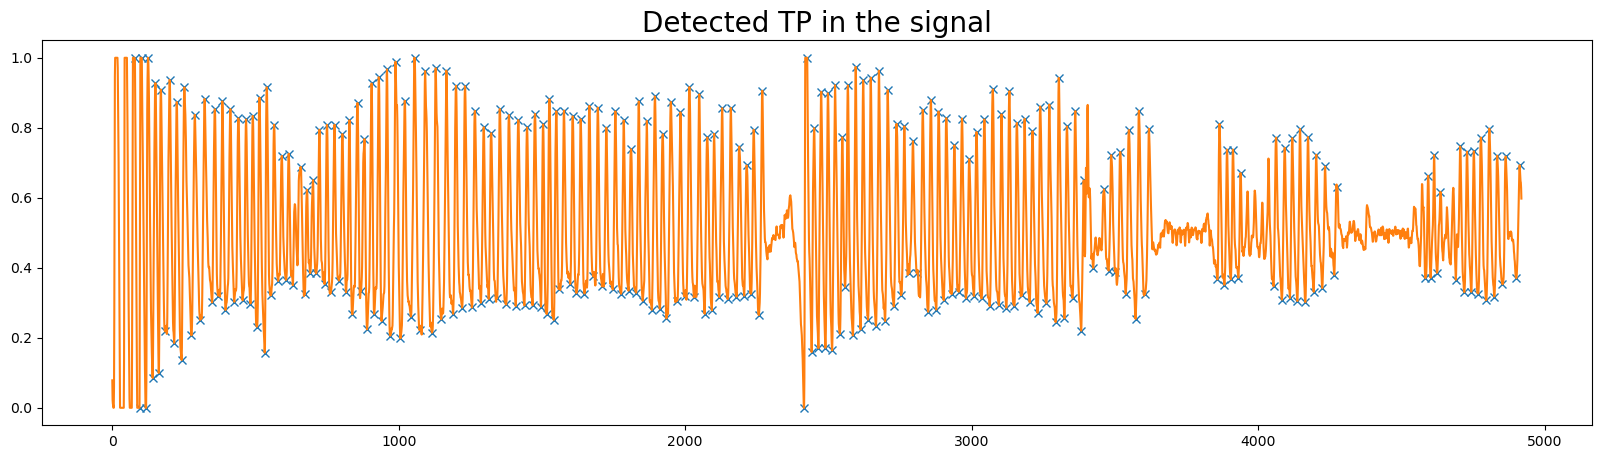

In [93]:
# latency,num_slope,num_label = 10,1,15
latency,num_slope,num_label = 9,3,15
TP_det_list,TP_det_index_list = [],[]
InEx_label,last_i_arr = -1, -2
iterate_Pred = 1

# detect all TP of preprocessed signal
for i_arr in range(len(Y_arr)):
    if i_arr % iterate_Pred != 0:
        continue
    else:
        #start_time = time.time()
        
        ref_TP,label_TP = False,False
        ref_TP,label_TP = TP_dect(Y_arr[i_arr],latency,num_slope,num_label)
        if ref_TP and label_TP * InEx_label == -1:
            TP_pot_index = ref_TP + i_arr + num_input
            TP_pot       = Y_arr[i_arr][ref_TP]
            # save the TP potential
            last_pot_index,last_pot,last_pot_label,last_i_arr = TP_pot_index, TP_pot, label_TP, i_arr
            
        elif (ref_TP and i_arr - last_i_arr == iterate_Pred and label_TP * InEx_label == 1):
            TP_det_index, TP_det, InEx_label = last_pot_index, last_pot, -InEx_label
            TP_det_index_list.append(TP_det_index)
            TP_det_list.append(TP_det)
        
        # if last time has TP, this time no TP, the TP is the 'TP'
        elif (i_arr - last_i_arr == iterate_Pred and InEx_label * last_pot_label == -1):
            TP_det_index, TP_det, InEx_label = last_pot_index, last_pot, -InEx_label
            TP_det_index_list.append(TP_det_index)
            TP_det_list.append(TP_det)
# plot the all detected TP in processed signal
#'''            
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['figure.dpi'] = 100
plt.plot(TP_det_index_list,TP_det_list,'x')
plt.title('Detected TP in the signal',fontsize = 20)
plt.plot(origin)
plt.show()
#'''

x = np.arange(0, 100, 1)
y1 = np.sin(x)
y2 = np.sin(x)+10
y3 = np.sin(x)+20
y4 = np.sin(x)+30
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(x[:50], y1[:50], c='r')
ax.plot(x[50:60], y1[50:60], c='b')
ax.plot(x[50:65], y2[50:65], c='g')
ax.plot(x[2:52], y3[2:52], c='r')
ax.plot(x[52:62], y3[52:62], c='b')
ax.plot(x[52:67], y4[52:67], c='g')
plt.show()


In [64]:
a, _ = TP_dect(Y_arr[9], latency, num_slope, num_label)
a

6

ValueError: x and y must have same first dimension, but have shapes (50,) and (51,)

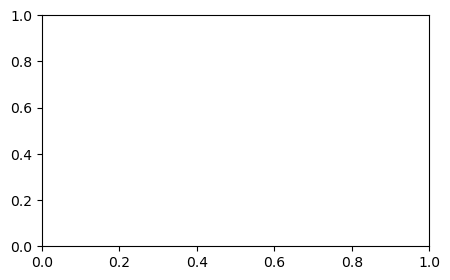

In [21]:
sample = sample.squeeze()
origin = test_data_list[0][50:73]
origin = real_time_sig_process(origin, win_len=9, sav_order=5)[4:19]
x1 = np.arange(50)
x2 = np.arange(50, 65)
fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(x1, sample, c='r')
ax.plot(x2, origin, c='b')
ax.plot(x2, pred, c='g')

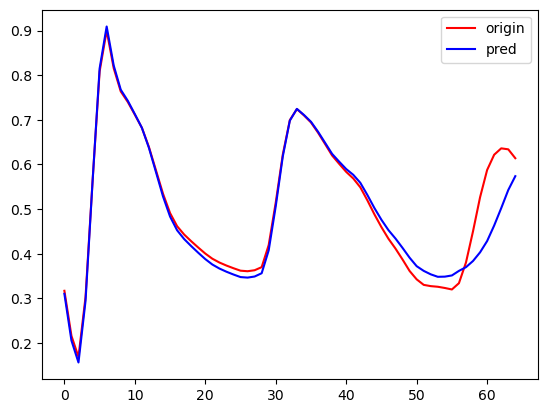

In [79]:
y1 = test_data_list[0][:73]
y1 = real_time_sig_process(y1, win_len=9, sav_order=5)[4:69]
y2 = sample.tolist() + pred.tolist()
x = np.arange(65)
fig, bx = plt.subplots(1, 1)
bx.plot(x, y1, c='r', label='origin')
bx.plot(x, y2, c='b', label='pred')
bx.legend()
